In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, lr_scheduler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
# import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from datetime import datetime
from enum import Enum
import math
# import hdf5storage
import h5py
from typing import Dict, List, Tuple, Optional, Union

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

/tmp/ipykernel_19/368343941.py:23: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
class Config:
    def __init__(self):
        # Dataset and DataLoader Parameters
        self.IMG_SIZE = (256, 256)
        self.BATCH_SIZE = 16
        self.TRAIN_RATIO = 0.8
        self.TEST_RATIO = 0.2

        # Training Parameters
        self.EPOCHS = 150
        self.LEARNING_RATE = 1e-3
        self.WEIGHT_DECAY = 1e-4
        self.LEARNING_RATE_MIN = 1e-6
        self.ACCUMALATION_STEPS = 1
        self.DICE_LOSS = True
        self.PATIENCE = 150

        # Model Parameters
        self.IN_CHANNELS = 1
        self.OUT_CLASSES = 1
        self.DEPTH = 5
        self.INIT_FEATURES = 34
        self.NORMALIZATION = 'batch'
        self.INTERPOLATION = 'nearest'
        self.OUT_ACTIVATION = 'sigmoid'
        self.USE_MULTIPLIER = False

        # Other Parameters
        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.SEED = 42
        self.ROOT = "/kaggle/input/brain-tumor-dataset/data/"
        self.SAVE_DIR = '/kaggle/working/resunet_checkpoint'

config = Config()

In [3]:
def set_all_seeds(seed):
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For multi-GPU setups
    # Ensures that the CUDA convolutions are deterministic, but might slow down training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Set to False for reproducibility

set_all_seeds(config.SEED)

In [4]:
class ClassesLabels(Enum):
    """Brain tumor classification labels"""
    Meningioma = 1  # U màng não
    Glioma = 2      # U thần kinh đệm  
    Pituitary = 3   # Tuyến uyên
    
    def __len__(self):
        return 3


class BrainTumorDataset(Dataset):
    """
    Brain tumor dataset with balanced class distribution
    
    Args:
        root: Root directory containing class folders
        train: If True, creates training set; if False, creates test set 
        classes: Tuple of classes to include
        test_freq: Fraction of data to use for testing
        random_seed: Random seed for reproducible splits
        normalize_image: Whether to normalize images to 0-255 range
        verbose: Whether to print dataset statistics
    """
    
    CLASS_FOLDERS = {
        ClassesLabels.Meningioma: 'meningioma',
        ClassesLabels.Glioma: 'glioma',
        ClassesLabels.Pituitary: 'pituitary'
    }
    
    def __init__(
        self,
        root: str,
        train: bool = True,
        classes: Tuple[ClassesLabels, ...] = (ClassesLabels.Meningioma, ClassesLabels.Glioma, ClassesLabels.Pituitary),
        test_freq: float = 0.15,
        random_seed: int = 42,
        normalize_image: bool = True,
        verbose: bool = True
    ):
        super().__init__()
        self.root = self._validate_path(root)
        self.train = train
        self.classes = classes
        self.test_freq = test_freq
        self.normalize_image = normalize_image
        
        # Set random seed for reproducible splits
        np.random.seed(random_seed)
        
        # Load and split data
        self.items, self.class_info = self._load_and_split_data()
        
        if verbose:
            self._print_stats()
    
    def _validate_path(self, path: str) -> str:
        """Validate and normalize root path"""
        if not os.path.exists(path):
            raise ValueError(f"Root path does not exist: {path}")
        return os.path.normpath(path)
    
    def _load_and_split_data(self) -> Tuple[List[str], Dict]:
        """Load files and split into train/test per class"""
        items = []
        class_info = {}
        
        for class_label in self.classes:
            folder_name = self.CLASS_FOLDERS[class_label]
            folder_path = os.path.join(self.root, folder_name)
            
            if not os.path.exists(folder_path):
                print(f"Warning: Folder {folder_path} does not exist!")
                continue
            
            # Get all valid files for this class
            all_files = self._get_valid_files(folder_path)
            if not all_files:
                print(f"Warning: No valid files found in {folder_path}")
                continue
            
            # Split files for this class
            train_files, test_files = self._split_files(all_files)
            selected_files = train_files if self.train else test_files
            
            # Add to items with folder prefix
            items.extend([f'{folder_name}/{f}' for f in selected_files])
            
            # Store class statistics
            class_info[class_label.name] = {
                'total': len(all_files),
                'train': len(train_files),
                'test': len(test_files),
                'selected': len(selected_files)
            }
        
        return items, class_info
    
    def _get_valid_files(self, folder_path: str) -> List[str]:
        """Get all valid data files from folder"""
        valid_extensions = ('.mat', '.h5', '.hdf5')
        files = [f for f in os.listdir(folder_path) 
                if f.lower().endswith(valid_extensions)]
        return sorted(files)  # Sort for consistent ordering
    
    def _split_files(self, files: List[str]) -> Tuple[List[str], List[str]]:
        """Split files into train and test sets"""
        files_shuffled = files.copy()
        np.random.shuffle(files_shuffled)
        
        split_point = math.floor((1 - self.test_freq) * len(files_shuffled))
        train_files = files_shuffled[:split_point]
        test_files = files_shuffled[split_point:]
        
        return train_files, test_files
    
    def _normalize_image(self, image: np.ndarray) -> np.ndarray:
        """Normalize image to 0-255 range using MATLAB formula"""
        im1 = image.astype(np.float64)
        min_val, max_val = np.min(im1), np.max(im1)
        
        if max_val == min_val:
            return np.zeros_like(im1, dtype=np.uint8)
        
        im_normalized = 255.0 * (im1 - min_val) / (max_val - min_val)
        return im_normalized.astype(np.uint8)
    
    def _print_stats(self):
        """Print dataset statistics"""
        mode = "Training" if self.train else "Testing"
        print(f"\n=== {mode} Dataset Statistics ===")
        print(f"Total samples: {len(self.items)}")
        print(f"Test frequency: {self.test_freq}")
        
        if self.class_info:
            print("\nClass breakdown:")
            total_selected = sum(info['selected'] for info in self.class_info.values())
            
            for class_name, info in self.class_info.items():
                percentage = (info['selected'] / total_selected * 100) if total_selected > 0 else 0
                print(f"  {class_name}: {info['selected']} ({percentage:.1f}%) "
                      f"[Total: {info['total']}, Train: {info['train']}, Test: {info['test']}]")
        print("=" * 50)
    
    def get_class_distribution(self) -> Dict[str, int]:
        """Get class distribution in current dataset"""
        return {name: info['selected'] for name, info in self.class_info.items()}
    
    def __len__(self) -> int:
        return len(self.items)
    
    def __getitem__(self, idx: int) -> Dict:
        if not (0 <= idx < len(self.items)):
            raise IndexError(f"Index {idx} out of range [0, {len(self.items)})")
        
        file_path = os.path.join(self.root, self.items[idx])
        
        try:
            with h5py.File(file_path, 'r') as f:
                data = f['cjdata']
                
                raw_image = data['image'][:]
                mask = data['tumorMask'][:]
                label = int(data['label'][0][0])
                
                # Apply normalization if requested
                image = self._normalize_image(raw_image) if self.normalize_image else raw_image
                
                return {
                    "label": label,
                    "image": image,
                    "mask": mask,
                    "file_path": self.items[idx]
                }
        
        except Exception as e:
            raise RuntimeError(f"Error loading {file_path}: {str(e)}")


class BrainTumorDatasetMask(BrainTumorDataset):
    """Dataset that returns (image, mask) tuples for backward compatibility"""
    
    def __init__(self, root: str, train: bool = True, transform=None, **kwargs):
        super().__init__(root=root, train=train, **kwargs)
        self.transform = transform
    
    def __getitem__(self, idx: int) -> Union[Tuple[np.ndarray, np.ndarray], any]:
        metadata = super().__getitem__(idx)
        sample = (metadata["image"], metadata["mask"])
        
        return self.transform(*sample) if self.transform else sample

In [5]:
def inspect_sample(dataset: BrainTumorDataset, idx: int = 0):
    """Inspect a dataset sample"""
    if len(dataset) == 0:
        print("Dataset is empty!")
        return
    
    sample = dataset[idx]
    print(f"\n=== Sample {idx} Inspection ===")
    
    if isinstance(sample, dict):
        print(f"Label: {sample['label']}")
        print(f"Image shape: {sample['image'].shape}, dtype: {sample['image'].dtype}")
        print(f"Image range: [{sample['image'].min()}, {sample['image'].max()}]")
        print(f"Mask shape: {sample['mask'].shape}, dtype: {sample['mask'].dtype}")
        print(f"File: {sample['file_path']}")
    else:
        print(f"Sample type: {type(sample)}")
        if isinstance(sample, tuple) and len(sample) == 2:
            image, mask = sample
            print(f"Image shape: {image.shape}, dtype: {image.dtype}")
            print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
    
    print("=" * 35)

In [6]:
dataset_mask = BrainTumorDatasetMask(root=config.ROOT, train=True, test_freq=0.2)
sample_mask = dataset_mask[0]  # Trả về (image, mask)
print(f"Mask dataset sample type: {type(sample_mask)}")

inspect_sample(dataset_mask, 0)


=== Training Dataset Statistics ===
Total samples: 2438
Test frequency: 0.2

Class breakdown:
  Meningioma: 566 (23.2%) [Total: 708, Train: 566, Test: 142]
  Glioma: 1140 (46.8%) [Total: 1426, Train: 1140, Test: 286]
  Pituitary: 732 (30.0%) [Total: 915, Train: 732, Test: 183]
Mask dataset sample type: <class 'tuple'>

=== Sample 0 Inspection ===
Sample type: <class 'tuple'>
Image shape: (512, 512), dtype: uint8
Mask shape: (512, 512), dtype: uint8


In [7]:
# Visualize function
def visualize(images, masks, original_images=None, original_masks=None):
    fontsize=18
    
    # Xử lý trường hợp input là single sample
    if not isinstance(images, (list, tuple)):
        images = [images]
        masks = [masks]
        if original_images is not None:
            original_images = [original_images]
        if original_masks is not None:
            original_masks = [original_masks]
    
    num_samples = len(images)
    
    if original_images is None and original_masks is None:
        # Hiển thị 2 hàng: hàng 1 là images, hàng 2 là masks
        f, ax = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
        
        # Nếu chỉ có 1 sample, ax sẽ là 1D array
        if num_samples == 1:
            ax = ax.reshape(2, 1)
        
        for i in range(num_samples):
            ax[0, i].imshow(images[i], cmap='gray')
            ax[0, i].set_title(f'Image {i+1}', fontsize=fontsize)
            ax[0, i].axis('off')
            
            ax[1, i].imshow(masks[i], cmap='gray')
            ax[1, i].set_title(f'Mask {i+1}', fontsize=fontsize)
            ax[1, i].axis('off')
    else:
        # Hiển thị 4 hàng: original images, original masks, transformed images, transformed masks
        f, ax = plt.subplots(4, num_samples, figsize=(4*num_samples, 16))
        
        # Nếu chỉ có 1 sample, ax sẽ là 1D array
        if num_samples == 1:
            ax = ax.reshape(4, 1)
        
        for i in range(num_samples):
            ax[0, i].imshow(original_images[i], cmap='gray')
            ax[0, i].set_title(f'Original Image {i+1}', fontsize=fontsize)
            ax[0, i].axis('off')
            
            ax[1, i].imshow(original_masks[i], cmap='gray')
            ax[1, i].set_title(f'Original Mask {i+1}', fontsize=fontsize)
            ax[1, i].axis('off')
            
            ax[2, i].imshow(images[i], cmap='gray')
            ax[2, i].set_title(f'Transformed Image {i+1}', fontsize=fontsize)
            ax[2, i].axis('off')
            
            ax[3, i].imshow(masks[i], cmap='gray')
            ax[3, i].set_title(f'Transformed Mask {i+1}', fontsize=fontsize)
            ax[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ví dụ sử dụng với multiple samples
def visualize_multiple_samples(dataset, indices, with_preprocessing=True):
    """
    Hiển thị nhiều samples từ dataset
    
    Args:
        dataset: Dataset object
        indices: List các index muốn hiển thị
        with_preprocessing: Có hiển thị ảnh trước và sau preprocessing không
    """
    images = []
    masks = []
    original_images = []
    original_masks = []
    
    for idx in indices:
        if with_preprocessing and hasattr(dataset, 'transform') and dataset.transform is not None:
            # Lấy dữ liệu gốc (không preprocessing)
            dataset_temp = dataset.__class__(dataset.root, dataset.train, transform=None, classes=dataset.classes)
            orig_img, orig_mask = dataset_temp[idx]
            original_images.append(orig_img)
            original_masks.append(orig_mask)
            
            # Lấy dữ liệu đã preprocessing
            proc_img, proc_mask = dataset[idx]
            images.append(proc_img.squeeze() if hasattr(proc_img, 'squeeze') else proc_img)
            masks.append(proc_mask.squeeze() if hasattr(proc_mask, 'squeeze') else proc_mask)
        else:
            # Chỉ lấy dữ liệu hiện tại
            img, mask = dataset[idx]
            images.append(img.squeeze() if hasattr(img, 'squeeze') else img)
            masks.append(mask.squeeze() if hasattr(mask, 'squeeze') else mask)
    
    if with_preprocessing and original_images:
        visualize(images, masks, original_images, original_masks)
    else:
        visualize(images, masks)

# Hàm tiền xử lí dữ liệu
def preprocessing(image, mask):
    image_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(config.IMG_SIZE, interpolation=0),
        # transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize image
        ])
    mask_transformer = transforms.Compose([
        transforms.Lambda(lambda x: transforms.ToPILImage()(transforms.ToTensor()(x).float().squeeze())),
        transforms.ToTensor(),
        transforms.Resize(config.IMG_SIZE, interpolation=0),
    ])
    # image = np.transpose(np.array(image)) / 65535.0
    # image = image * 2 - 1
    image = np.transpose(np.array(image))
    mask = np.transpose(np.array(mask))
    mask = mask_transformer(mask)
    mask = mask / mask.max()
    mask = torch.where(mask > 0.5, 1, 0).float()
    return image_transformer(image).float(), mask

In [8]:
# Khởi tạo dataset
dataset = BrainTumorDatasetMask(root='/kaggle/input/brain-tumor-dataset/data/', train=True, transform=preprocessing)
original_image, original_mask = dataset[3]
print(f'#=>Original image: {type(original_image)}')
print(f'#=>Original mask: {type(original_mask)}')


=== Training Dataset Statistics ===
Total samples: 2590
Test frequency: 0.15

Class breakdown:
  Meningioma: 601 (23.2%) [Total: 708, Train: 601, Test: 107]
  Glioma: 1212 (46.8%) [Total: 1426, Train: 1212, Test: 214]
  Pituitary: 777 (30.0%) [Total: 915, Train: 777, Test: 138]
#=>Original image: <class 'torch.Tensor'>
#=>Original mask: <class 'torch.Tensor'>


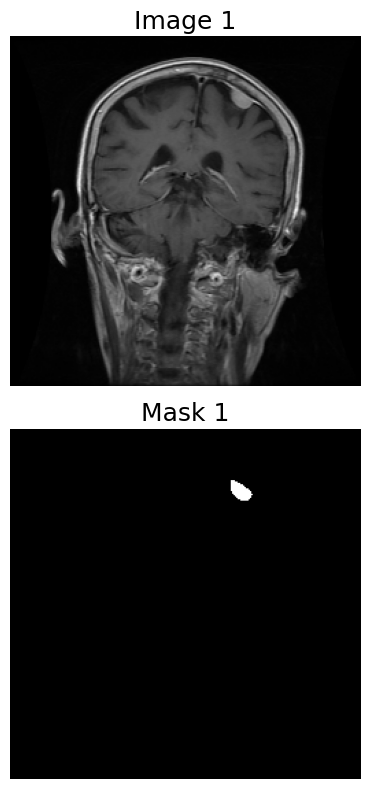

In [9]:
visualize(original_image.squeeze(), original_mask.squeeze())


=== Training Dataset Statistics ===
Total samples: 2590
Test frequency: 0.15

Class breakdown:
  Meningioma: 601 (23.2%) [Total: 708, Train: 601, Test: 107]
  Glioma: 1212 (46.8%) [Total: 1426, Train: 1212, Test: 214]
  Pituitary: 777 (30.0%) [Total: 915, Train: 777, Test: 138]

=== Training Dataset Statistics ===
Total samples: 2590
Test frequency: 0.15

Class breakdown:
  Meningioma: 601 (23.2%) [Total: 708, Train: 601, Test: 107]
  Glioma: 1212 (46.8%) [Total: 1426, Train: 1212, Test: 214]
  Pituitary: 777 (30.0%) [Total: 915, Train: 777, Test: 138]

=== Training Dataset Statistics ===
Total samples: 2590
Test frequency: 0.15

Class breakdown:
  Meningioma: 601 (23.2%) [Total: 708, Train: 601, Test: 107]
  Glioma: 1212 (46.8%) [Total: 1426, Train: 1212, Test: 214]
  Pituitary: 777 (30.0%) [Total: 915, Train: 777, Test: 138]

=== Training Dataset Statistics ===
Total samples: 2590
Test frequency: 0.15

Class breakdown:
  Meningioma: 601 (23.2%) [Total: 708, Train: 601, Test: 107]
  

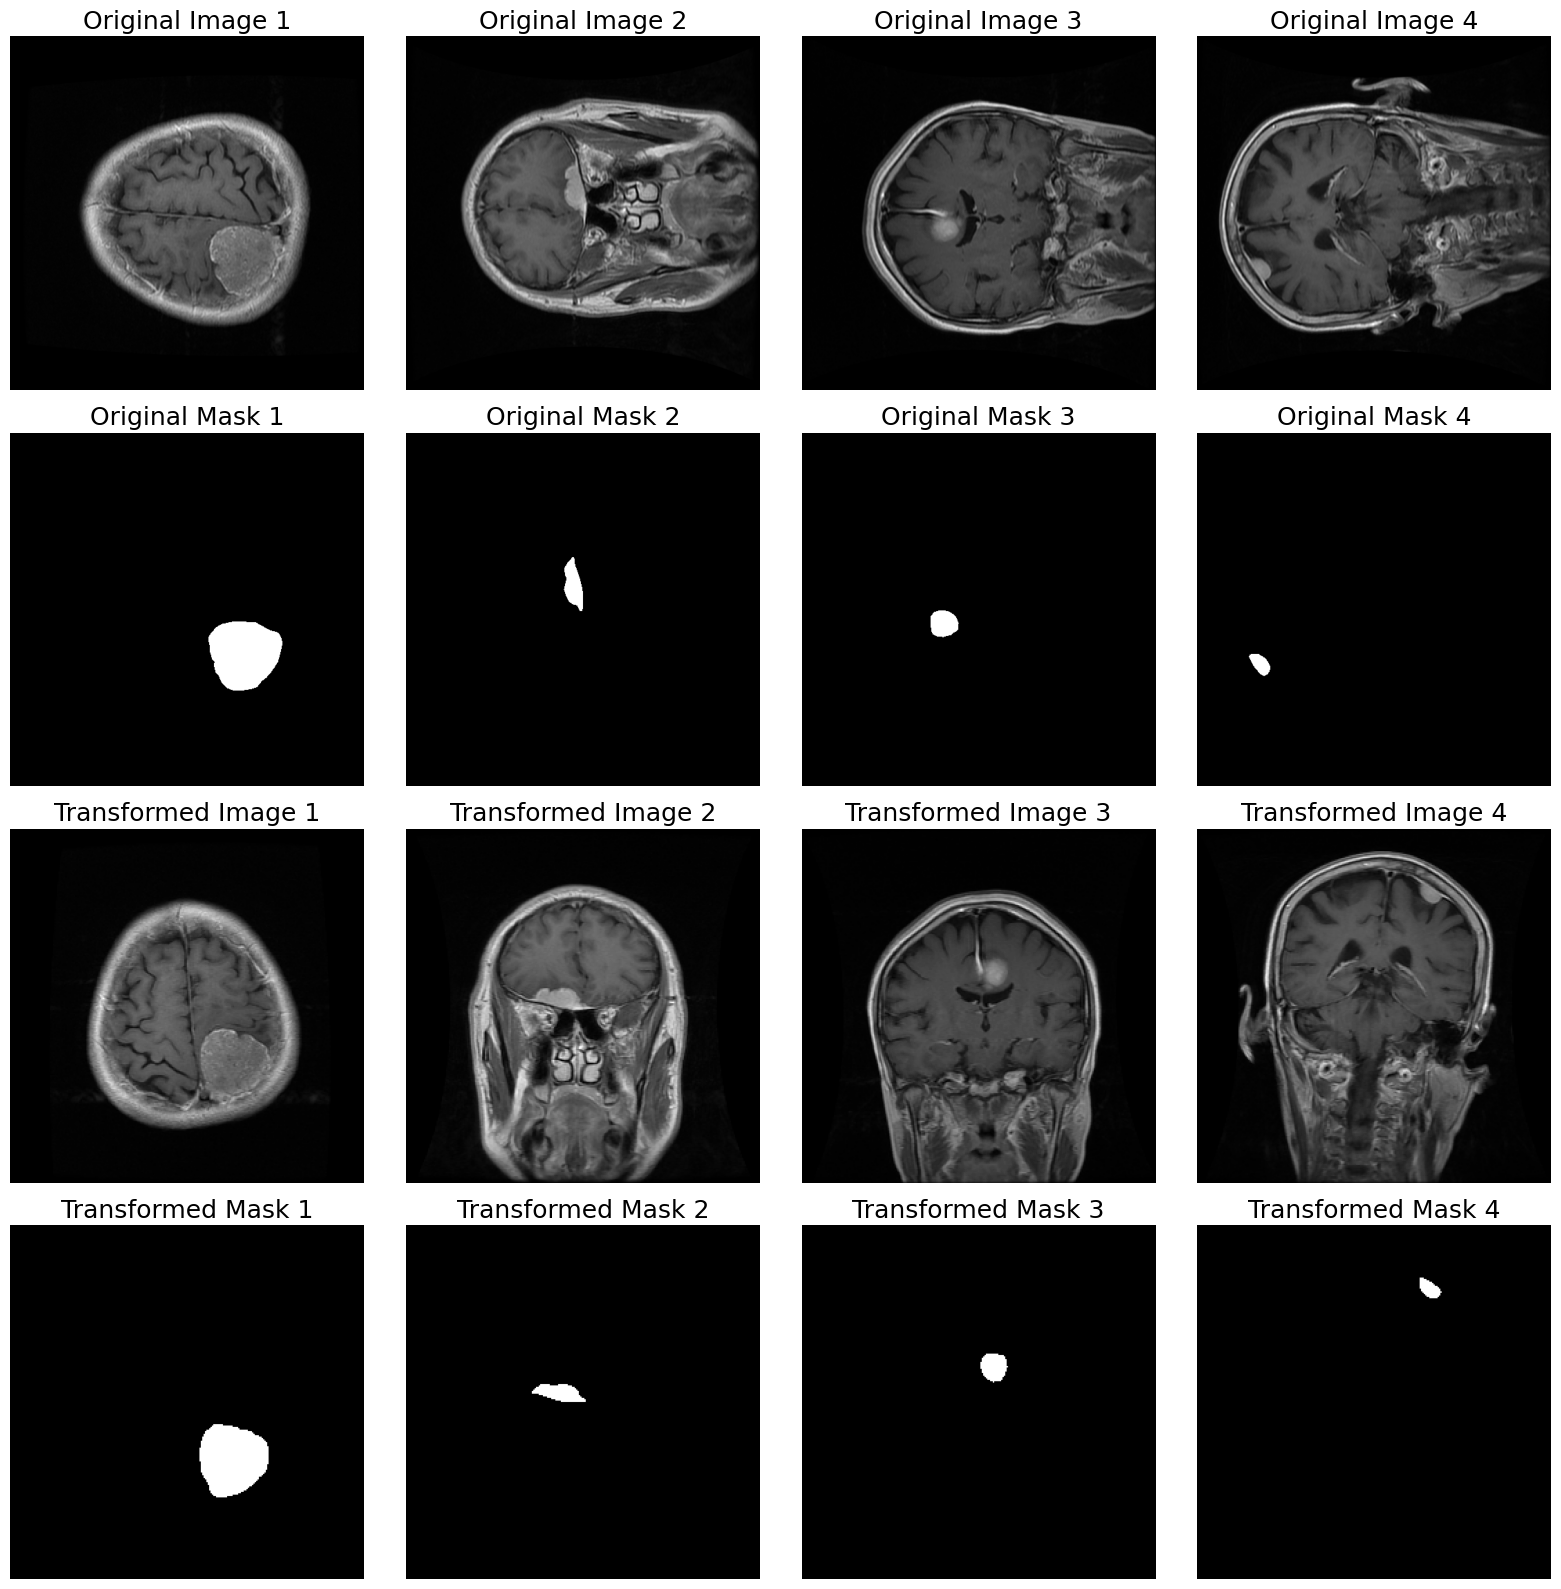

In [10]:
visualize_multiple_samples(dataset, [0, 1, 2, 3])

In [11]:
class PreActivateDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.double_conv(x)

class PreActivateResUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResUpBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x) + self.ch_avg(x)

class PreActivateResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))

        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        identity = self.ch_avg(x)
        out = self.double_conv(x)
        out = out + identity
        return self.down_sample(out), out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.double_conv(x)
        out = self.relu(out + identity)
        return self.down_sample(out), out


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, out_classes=1):
        super(UNet, self).__init__()

        self.down_conv1 = DownBlock(1, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)

        self.double_conv = DoubleConv(512, 1024)

        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.act_last = nn.Sigmoid()

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.act_last(x)
        return x

class DeepResUNet(nn.Module):
    def __init__(self, out_classes=1):
        super(DeepResUNet, self).__init__()

        self.down_conv1 = PreActivateResBlock(1, 64)
        self.down_conv2 = PreActivateResBlock(64, 128)
        self.down_conv3 = PreActivateResBlock(128, 256)
        self.down_conv4 = PreActivateResBlock(256, 512)

        self.double_conv = PreActivateDoubleConv(512, 1024)

        self.up_conv4 = PreActivateResUpBlock(512 + 1024, 512)
        self.up_conv3 = PreActivateResUpBlock(256 + 512, 256)
        self.up_conv2 = PreActivateResUpBlock(128 + 256, 128)
        self.up_conv1 = PreActivateResUpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

class ResUNet(nn.Module):
    """
    Hybrid solution of resnet blocks and double conv blocks
    """
    def __init__(self, out_classes=1):
        super(ResUNet, self).__init__()

        self.down_conv1 = ResBlock(1, 64)
        self.down_conv2 = ResBlock(64, 128)
        self.down_conv3 = ResBlock(128, 256)
        self.down_conv4 = ResBlock(256, 512)

        self.double_conv = DoubleConv(512, 1024)

        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.act_last = nn.Sigmoid()

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.act_last(x)
        return x

class ONet(nn.Module):
    def __init__(self, alpha=470, beta=40, out_classes=1):
        super(ONet, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.down_conv1 = ResBlock(1, 64)
        self.down_conv2 = ResBlock(64, 128)
        self.down_conv3 = ResBlock(128, 256)
        self.down_conv4 = ResBlock(256, 512)

        self.double_conv = DoubleConv(512, 1024)

        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)
        self.input_output_conv = nn.Conv2d(2, 1, kernel_size=1)


    def forward(self, inputs):
        input_tensor, bounding = inputs
        x, skip1_out = self.down_conv1(input_tensor + (bounding * self.alpha))
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        input_output = torch.cat([x, bounding * self.beta], dim=1)
        x = self.input_output_conv(input_output)
        return x

In [12]:
class Trainer():
    def __init__(self,
                 model,
                 train_dataloader,
                 valid_dataloader,
                 epochs=10,
                 save_dir=None,
                 device='cpu',
                 accumalation_steps=4,
                 patience=5):  # Add patience for early stopping
        self.device = device
        self.accumalation_steps = accumalation_steps

        self.model = model.to(self.device)

        self.train_losses = []
        self.train_dice_coeff_values = []
        self.train_iou_values = []
        self.val_losses = []
        self.val_dice_coeff_values = []
        self.val_iou_values = []
        self.patience = patience  # Early stopping patience
        self.early_stop = False  # Flag for early stopping
        self.best_valid_loss = float('inf')  # Initialize best loss

        if save_dir != None and os.path.exists(save_dir):
            print("Load weight from file:{}".format(save_dir))
            self.save_dir = save_dir
            epcho_checkpoint_path = glob.glob("{}/model_epoch*".format(self.save_dir))
            if len(epcho_checkpoint_path) == 0:
                print("No checkpoint found in: {}\nCheck save_dir...".format(self.save_dir))
            else:
                self.load_checkpoint(epcho_checkpoint_path[0])
                print("Restore weight successful from: {}".format(epcho_checkpoint_path))
        else:
            self.save_dir = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
            os.makedirs(self.save_dir)
            print("Training new model, save to: {}".format(self.save_dir))

        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.epochs = epochs

    def save_checkpoint(self, save_path):
        state_dict = {'model_state_dict': self.model.state_dict(),
                      'train_losses': self.train_losses,
                      'train_dice_coeff_values': self.train_dice_coeff_values,
                      'train_iou_values': self.train_iou_values,
                      'val_losses': self.val_losses,
                      'val_dice_coeff_values': self.val_dice_coeff_values,
                      'val_iou_values': self.val_iou_values
                     }
        torch.save(state_dict, save_path)
        print(f"Model saved to ==> {save_path}")

    def load_checkpoint(self, load_path):
        state_dict = torch.load(load_path, map_location=self.device)
        print(f"Model restored from <== {load_path}")
        self.model.load_state_dict(state_dict["model_state_dict"])
        self.train_losses = state_dict["train_losses"]
        self.train_dice_coeff_values = state_dict["train_dice_coeff_values"]
        self.train_iou_values = state_dict['train_iou_values']
        self.val_losses = state_dict["val_losses"]
        self.val_dice_coeff_values = state_dict["val_dice_coeff_values"]
        self.val_iou_values = state_dict['val_iou_values']

    @staticmethod
    def iou(pred_mask, true_mask):
        # Làm phẳng các tensor
        pred_mask = pred_mask.view(-1)
        true_mask = true_mask.view(-1)
    
        # Tính toán phần giao nhau và hợp nhất
        intersection = torch.sum(pred_mask * true_mask)
        union = torch.sum(pred_mask) + torch.sum(true_mask) - intersection
    
        # Tính IoU
        iou = intersection / union
    
        return iou

    @staticmethod
    def dice_loss(pred, target, smooth=1e-6):
        pred = pred.view(-1)
        target = target.view(-1)
        
        # Flatten the tensors to calculate the intersection and union of predicted and true masks
        intersection = torch.sum(pred * target)
        union = torch.sum(pred) + torch.sum(target)
        
        # Compute Dice coefficient
        dice = (2. * intersection + smooth) / (union + smooth)
        
        return 1 - dice

    @staticmethod
    def dice_coeff(pred, target, smooth=1e-6, threshold=0.5):
        pred = pred.view(-1)
        target = target.view(-1)
        # pred = (pred > threshold).float()
        
        intersection = torch.sum(pred * target)
        union = torch.sum(pred) + torch.sum(target)
        return (2. * intersection + smooth) / (union + smooth)
    
    def train(self):
        if config.DICE_LOSS:
            criterion = self.dice_loss
        else:
            criterion = nn.BCELoss()
            
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.EPOCHS, eta_min=config.LEARNING_RATE_MIN)
        
        patience_counter = 0  # Track epochs without improvement
        for epoch_i in range(0, self.epochs):
            if self.early_stop:  # Check if early stopping is triggered
                print("Early stopping triggered. Training stopped.")
                break

            print('========== Epoch {:} / {:} =========='.format(epoch_i + 1, self.epochs))
            print('Training...')

            total_loss = 0
            self.model.train()
            nb_train_steps = 0
            train_iou = 0
            train_dice_coeff = 0

            for step, batch in enumerate(self.train_dataloader):
                img, mask = batch
                img, mask = img.to(self.device), mask.to(self.device)
                
                outputs = self.model(img)

                dice = self.dice_coeff(outputs.detach(), mask).item()
                train_dice_coeff += dice
                iou = self.iou(outputs.detach(), mask).item()
                train_iou += iou

                loss = criterion(outputs, mask) / self.accumalation_steps
                total_loss += loss.item() * self.accumalation_steps
                
                nb_train_steps += 1

                loss.backward()
                if (step + 1) % self.accumalation_steps == 0:
                    optimizer.step()
                    # scheduler.step()
                    optimizer.zero_grad()

                if (step + 1) % 10 == 0:
                    print("[TRAIN] Epoch {}/{} | Batch {}/{} | Loss={:.4f} | Dice_coeff={:.4f} | IoU={:.4f}".format(epoch_i + 1, self.epochs, step + 1, len(self.train_dataloader), loss.item(), dice, iou))

            scheduler.step()
            avg_train_loss = total_loss / len(self.train_dataloader)
            avg_train_dice_coeff = train_dice_coeff / nb_train_steps
            avg_train_iou = train_iou / nb_train_steps
            print(" Train Loss: {:.4f} | Avg_dice_coeff: {:.4f} | Avg_IoU: {:.4f}".format(avg_train_loss, avg_train_dice_coeff, avg_train_iou))

            self.train_losses.append(avg_train_loss)
            self.train_dice_coeff_values.append(avg_train_dice_coeff)
            self.train_iou_values.append(avg_train_iou)

            print("Running Validation...")
            self.model.eval()
            eval_loss = 0
            eval_iou = 0
            eval_dice_coeff = 0
            nb_eval_steps = 0

            for batch in self.valid_dataloader:
                img, mask = batch
                img, mask = img.to(self.device), mask.to(self.device)

                with torch.no_grad():
                    outputs = self.model(img)

                    loss = criterion(outputs, mask)       
                    eval_dice_coeff += self.dice_coeff(outputs.detach(), mask).item()
                    eval_iou += self.iou(outputs.detach(), mask).item()
                    eval_loss += loss.item()
                    nb_eval_steps += 1

            avg_val_loss = eval_loss / nb_eval_steps
            avg_val_dice_coeff = eval_dice_coeff / nb_eval_steps
            avg_val_iou = eval_iou / nb_eval_steps
            
            print(f" Valid Loss: {avg_val_loss:.4f} | Dice_coeff: {avg_val_dice_coeff:.4f} | IoU: {avg_val_iou:.4f}")

            self.val_losses.append(avg_val_loss)
            self.val_dice_coeff_values.append(avg_val_dice_coeff)
            self.val_iou_values.append(avg_val_iou)

            # Early stopping logic
            if avg_val_loss  < self.best_valid_loss:
                print(f"Validation loss improved from {self.best_valid_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
                self.best_valid_loss = avg_val_loss
                patience_counter = 0  # Reset patience counter
                best_valid_loss_path = "{}/model_best_valloss.pt".format(self.save_dir)
                self.save_checkpoint(best_valid_loss_path)
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter} epochs.")
                if patience_counter >= self.patience:
                    print(f"Stopping early after {patience_counter} epochs without improvement.")
                    self.early_stop = True

            # Save checkpoint for current epoch
            epoch_i_path = "{}/model_epoch{}.pt".format(self.save_dir, epoch_i)
            self.save_checkpoint(epoch_i_path)

            # Remove the previous epoch's checkpoint
            if os.path.exists("{}/model_epoch{}.pt".format(self.save_dir, epoch_i-1)):
                os.remove("{}/model_epoch{}.pt".format(self.save_dir, epoch_i-1))

        print("Training complete!")
        
    def eval(self, dataloader):
        self.model.eval()
        if config.DICE_LOSS:
            criterion = self.dice_loss
        else:
            criterion = nn.BCELoss()
        nb_eval_steps = 0
        eval_loss = 0
        eval_iou = 0
        eval_dice_coeff = 0
        for step, batch in enumerate(dataloader):
            img, mask = batch
            img, mask = img.to(self.device), mask.to(self.device)

            with torch.no_grad():
                outputs = self.model(img)

                loss = criterion(outputs, mask)
                
                eval_dice_coeff += self.dice_coeff(outputs.detach(), mask).item()
                eval_iou += self.iou(outputs.detach(), mask).item()
                eval_loss += loss.item()
                nb_eval_steps += 1
                
            if (step + 1) % 100 == 0:
                    print("[Test] Batch {}/{} | Test Loss={:.4f}".format(step + 1, len(dataloader), loss))
        avg_val_loss = eval_loss / nb_eval_steps
        avg_dice_coeff = eval_dice_coeff / nb_eval_steps
        avg_iou = eval_iou / nb_eval_steps
        
        print(f" Test Loss: {avg_val_loss:.4f} | Dice_coeff: {avg_dice_coeff:.4f} | IoU: {avg_iou:.4f}")
        return

    def visualize_scores(self):
        num_epoches = range(1, len(self.train_losses) + 1)
        # Vẽ Loss
        plt.figure(figsize=(12, 6))
        plt.plot(num_epoches, self.train_losses, label='Train Loss', marker='o', color='blue')
        plt.plot(num_epoches, self.val_losses, label='Test Loss', marker='o', color='orange')
        plt.title('Training and Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Vẽ Dice Coeff
        plt.figure(figsize=(12, 6))
        plt.plot(num_epoches, self.train_dice_coeff_values, label='Train Dice Coeff', marker='o', color='green')
        plt.plot(num_epoches, self.val_dice_coeff_values, label='Test Dice Coeff', marker='o', color='red')
        plt.title('Training and Testing Dice Coeff')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coeff')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Vẽ IoU
        plt.figure(figsize=(12, 6))
        plt.plot(num_epoches, self.train_iou_values, label='Train IoU', marker='o', color='green')
        plt.plot(num_epoches, self.val_iou_values, label='Test IoU', marker='o', color='red')
        plt.title('Training and Testing IoU')
        plt.xlabel('Epochs')
        plt.ylabel('IoU')
        plt.legend()
        plt.grid(True)
        plt.show()

In [13]:
train_dataset = BrainTumorDatasetMask(root=config.ROOT, train=True, 
                                      test_freq=config.TEST_RATIO, transform=preprocessing)
valid_dataset = BrainTumorDatasetMask(root=config.ROOT, train=False, 
                                      test_freq=config.TEST_RATIO, transform=preprocessing)
print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of test dataset: {len(valid_dataset)}')

train_loader = DataLoader(dataset=train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
print(f'Length of train loader: {len(train_loader)}')
print(f'Length of test loader: {len(valid_loader)}')


=== Training Dataset Statistics ===
Total samples: 2438
Test frequency: 0.2

Class breakdown:
  Meningioma: 566 (23.2%) [Total: 708, Train: 566, Test: 142]
  Glioma: 1140 (46.8%) [Total: 1426, Train: 1140, Test: 286]
  Pituitary: 732 (30.0%) [Total: 915, Train: 732, Test: 183]

=== Testing Dataset Statistics ===
Total samples: 611
Test frequency: 0.2

Class breakdown:
  Meningioma: 142 (23.2%) [Total: 708, Train: 566, Test: 142]
  Glioma: 286 (46.8%) [Total: 1426, Train: 1140, Test: 286]
  Pituitary: 183 (30.0%) [Total: 915, Train: 732, Test: 183]
Length of train dataset: 2438
Length of test dataset: 611
Length of train loader: 153
Length of test loader: 39


In [14]:
 def init_weights_with_kaiming_uniform(m):
        '''Initialize the weights of the model with kaiming uniform initialization.'''
        if type(m) == nn.Conv2d:
            torch.nn.init.kaiming_uniform_(m.weight)
            
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
model = ResUNet().to(config.DEVICE)
model = nn.DataParallel(model)
model.apply(init_weights_with_kaiming_uniform) # default init is xaiver uniform
    
print("Number parameters:", count_parameters(model))

Number parameters: 31563585


In [16]:
trainer = Trainer(
    model=model,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    epochs=config.EPOCHS,
    save_dir=config.SAVE_DIR,
    device=config.DEVICE,
    accumalation_steps=config.ACCUMALATION_STEPS,
    patience = config.PATIENCE
)

Training new model, save to: 18-06-2025_04-11-10


In [17]:
# trainer.load_checkpoint('/kaggle/working/17-06-2025_08-00-35/model_epoch0.pt')

In [18]:
trainer.train()

========== Epoch 1 / 150 ==========
Training...
[TRAIN] Epoch 1/150 | Batch 10/153 | Loss=0.9043 | Dice_coeff=0.0957 | IoU=0.0502
[TRAIN] Epoch 1/150 | Batch 20/153 | Loss=0.8147 | Dice_coeff=0.1853 | IoU=0.1021
[TRAIN] Epoch 1/150 | Batch 30/153 | Loss=0.8034 | Dice_coeff=0.1966 | IoU=0.1090
[TRAIN] Epoch 1/150 | Batch 40/153 | Loss=0.8315 | Dice_coeff=0.1685 | IoU=0.0920
[TRAIN] Epoch 1/150 | Batch 50/153 | Loss=0.7661 | Dice_coeff=0.2339 | IoU=0.1324
[TRAIN] Epoch 1/150 | Batch 60/153 | Loss=0.7665 | Dice_coeff=0.2335 | IoU=0.1322
[TRAIN] Epoch 1/150 | Batch 70/153 | Loss=0.6328 | Dice_coeff=0.3672 | IoU=0.2249
[TRAIN] Epoch 1/150 | Batch 80/153 | Loss=0.5365 | Dice_coeff=0.4635 | IoU=0.3017
[TRAIN] Epoch 1/150 | Batch 90/153 | Loss=0.7006 | Dice_coeff=0.2994 | IoU=0.1761
[TRAIN] Epoch 1/150 | Batch 100/153 | Loss=0.7309 | Dice_coeff=0.2691 | IoU=0.1554
[TRAIN] Epoch 1/150 | Batch 110/153 | Loss=0.5962 | Dice_coeff=0.4038 | IoU=0.2530
[TRAIN] Epoch 1/150 | Batch 120/153 | Loss=0.594

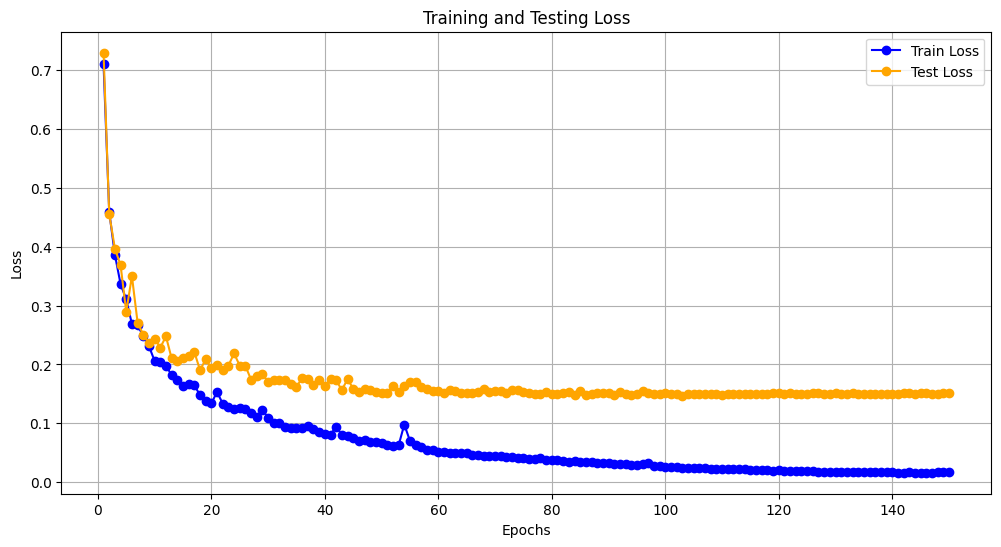

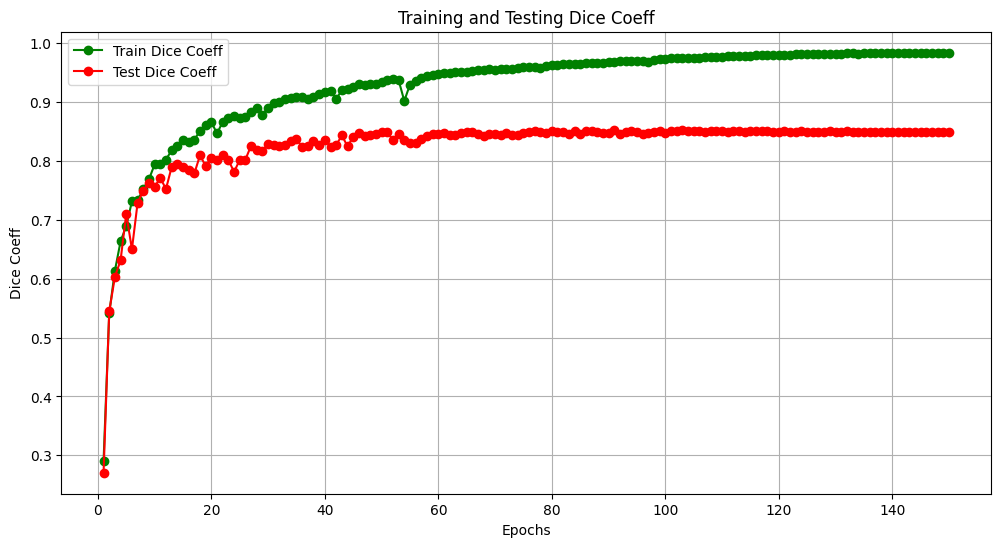

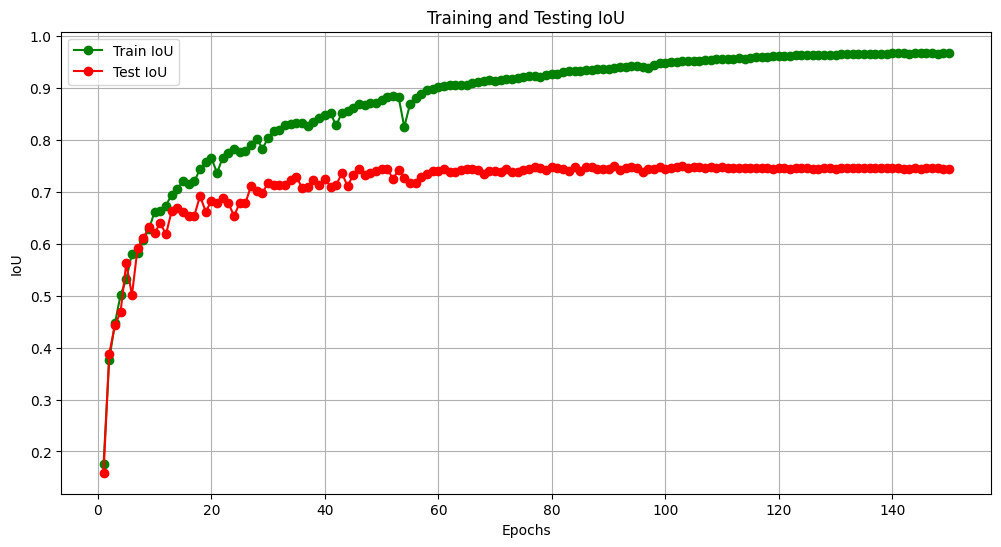

In [19]:
trainer.visualize_scores()

In [20]:
test_loader = DataLoader(dataset=valid_dataset, batch_size=1, shuffle=False)

trainer.eval(test_loader)

[Test] Batch 100/611 | Test Loss=0.0419
[Test] Batch 200/611 | Test Loss=0.1844
[Test] Batch 300/611 | Test Loss=0.6728
[Test] Batch 400/611 | Test Loss=0.4059
[Test] Batch 500/611 | Test Loss=0.9972
[Test] Batch 600/611 | Test Loss=0.0728
 Test Loss: 0.1938 | Dice_coeff: 0.8062 | IoU: 0.7233


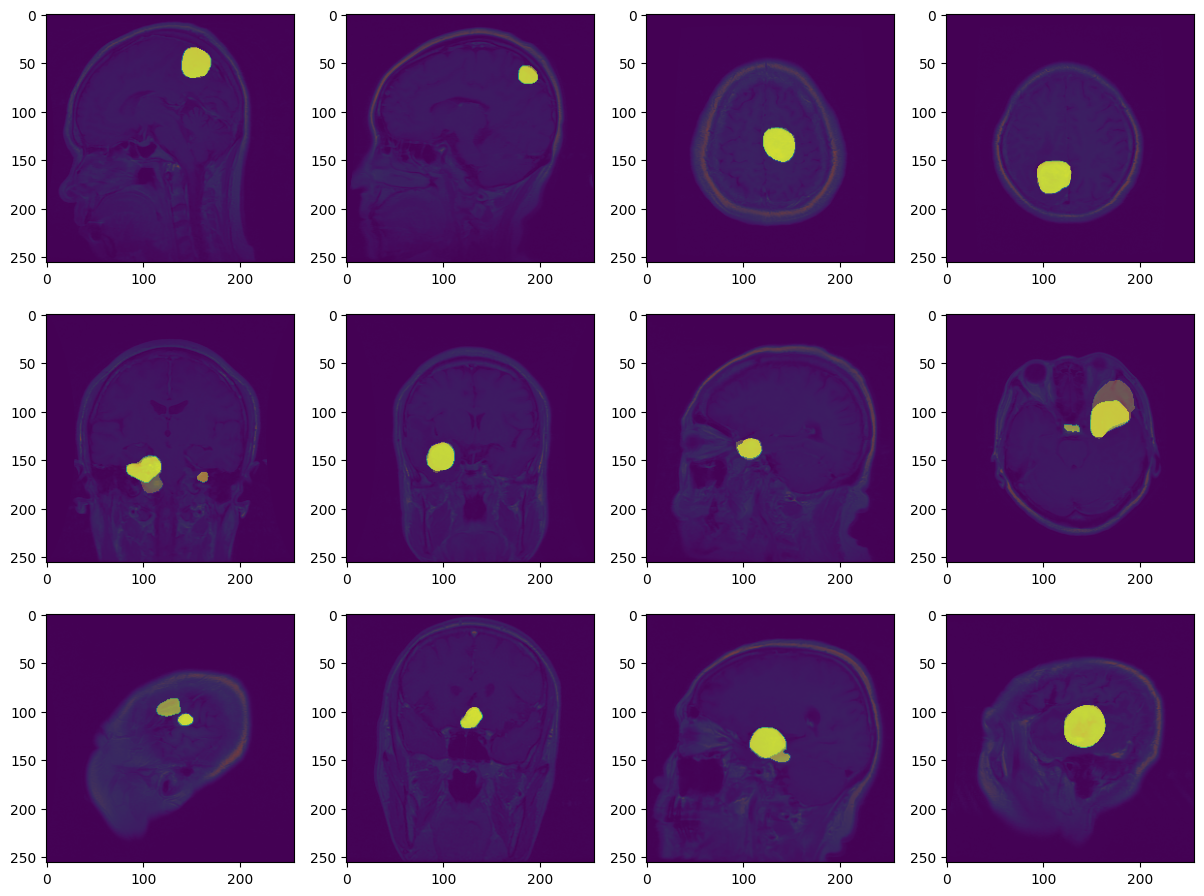

In [21]:
width = 4
columns = 3
n_examples = 12

fig, axs = plt.subplots(columns, width, figsize=(3*width , 3*columns), constrained_layout=True)
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0][0]
        if not mask.byte().any():
            continue
        image = image.to(config.DEVICE)
        prediction = trainer.model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        axs[i//width][i%width].imshow(mask, alpha=0.5)
        axs[i//width][i%width].imshow(prediction, alpha=0.5)
        if n_examples == i + 1:
            break
        i += 1